In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import surprise
from surprise import KNNWithMeans, Dataset, accuracy, BaselineOnly, Reader
from surprise.model_selection import KFold, train_test_split, cross_validate
from sklearn.metrics import auc, roc_curve
from collections import defaultdict

# Question 1

In [2]:
data = pd.read_csv('ml-latest-small/ratings.csv', usecols = [0,1,2])
rating_num = len(data)
print('Total number of available ratings:', rating_num)
data.head()
rating = data['rating'].values

Total number of available ratings: 100004


In [3]:
# Count the number of users involved
user = data['userId'].values
user_counts = dict()
for i in user:
    user_counts[i] = user_counts.get(i,0)+1
user_num = len(user_counts.keys())
print('Total number of users involved:', user_num)

Total number of users involved: 671


In [4]:
# Count the number of movies rated
movie = data['movieId'].values
movie_counts = dict()
for i in movie:
    movie_counts[i] = movie_counts.get(i,0)+1
movie_num = len(movie_counts.keys())
print('Total number of movies rated:', movie_num)

Total number of movies rated: 9066


In [5]:
# Calculate the Sparsity
sparsity = rating_num/(user_num*movie_num)
print('The sparsity of the movie rating dataset: %.3f' %sparsity)

The sparsity of the movie rating dataset: 0.016


In [6]:
# Construct the rating matrix
row = max(user_counts.keys())
col = max(movie_counts.keys())
R = np.zeros((row,col), dtype = float)
for i in range(0,rating_num):
    R[user[i]-1,movie[i]-1] = rating[i]
print(R.shape)

(671, 163949)


# Question 2

In [7]:
rating_values = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
rating_values_frequency = np.zeros(10)
for i in rating:
    value_index = int(i/0.5)-1
    rating_values_frequency[value_index] = rating_values_frequency[value_index]+1
rating_values_frequency = rating_values_frequency/rating_num

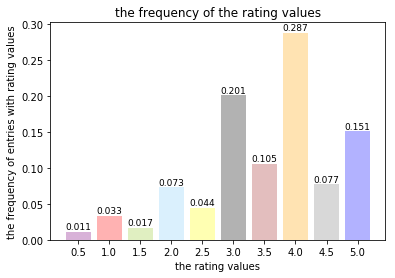

In [8]:
color = ['purple', 'red', 'yellowgreen', 'lightskyblue', 'yellow', 'black', 'brown', 'orange', 'gray', 'blue']
plt.bar(rating_values, rating_values_frequency, width = 0.4, color = color, alpha = 0.3)
plt.xticks(rating_values)
plt.xlabel('the rating values')
plt.ylabel('the frequency of entries with rating values')
plt.title('the frequency of the rating values')
for a,b in zip(rating_values, rating_values_frequency):
    plt.text(a, b+0.0005, '%.3f' % b, ha='center', va= 'bottom',fontsize=9)
plt.show()

# Question 3

In [9]:
# Sort the movie index ordered by decreasing frequency
movie_counts = sorted(movie_counts.items(), key = lambda m:m[1], reverse = True)
movieid = list()
movie_rating_num = list()
for Id,rate_num in movie_counts:
    movieid.append(Id)
    movie_rating_num.append(rate_num)

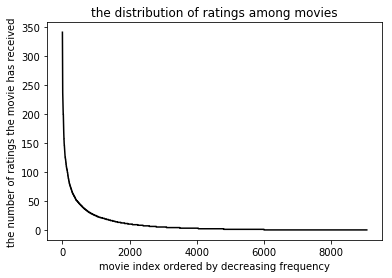

In [10]:
plt.plot(range(len(movieid)), movie_rating_num, color = 'black')
plt.xlabel('movie index ordered by decreasing frequency')
plt.ylabel('the number of ratings the movie has received')
plt.title('the distribution of ratings among movies')
plt.show()

# Question 4

In [11]:
# Sort the user index ordered by decreasing frequency
user_counts = sorted(user_counts.items(), key = lambda m:m[1], reverse = True)
userid = list()
user_rating_num = list()
for Id,rate_num in user_counts:
    userid.append(Id)
    user_rating_num.append(rate_num)

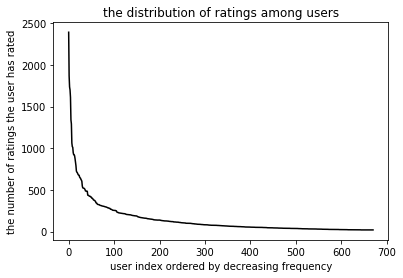

In [12]:
plt.plot(range(len(userid)), user_rating_num, color = 'black')
plt.xlabel('user index ordered by decreasing frequency')
plt.ylabel('the number of ratings the user has rated')
plt.title('the distribution of ratings among users')
plt.show()

# Question 5

According to the figure in question 3, it's evident that movies with a lot of ratings only account for a very small part of all the movies. In other words, more ratings concentrate on a small number of movies, resulting in the fact that the distribution of ratings is uneven.

As for the processing of the recommendation system, movies with more ratings have more user preference information, thus the recommendation for this part of the movies predicted by the system is based on more rating data, leading to more accurate recommendation result. On the contrary, the predictions and recommendations of the other part movies that have less ratings, some may only possessing one or two ratings, may not be accurate enough due to the information inadequacy.

# Question 6

In [13]:
movie_variance = list()
for m in movieid:
    tmp = list()
    for u in userid:
        if R[u-1,m-1] != 0:
            tmp.append(R[u-1,m-1])
    m_var = np.var(tmp)
    movie_variance.append(m_var)

In [14]:
number = dict()
for i in movie_variance:
    index = int(i/0.5)*0.5
    number[index] = number.get(index,0)+1

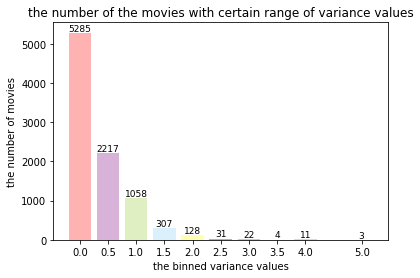

In [15]:
color = ['purple', 'red', 'yellowgreen', 'lightskyblue', 'yellow', 'black', 'brown', 'orange', 'gray', 'blue']
plt.bar(number.keys(), number.values(), width = 0.4, color = color, alpha = 0.3)
plt.xticks(list(number.keys()))
plt.xlabel('the binned variance values')
plt.ylabel('the number of movies')
plt.title('the number of the movies with certain range of variance values')
for a,b in zip(number.keys(), number.values()):
    plt.text(a, b+0.0005, '%.0f' % b, ha='center', va= 'bottom',fontsize=9)
plt.show()

The histogram shows the amount of movies with certain rating variance value. According to this figure, we can intuitively gain the observation that the overall trend of the histogram is exponential decline. The variance of the most movie ratings are at the range from 0 to 1.5, whose amounts are dominant to those of the others.

# Question 7

The formula for $\mu_u$ in terms of $ I_u $and $r_{u k}$ is like, 
$$\mu _u = \frac{\sum _{k \in I_u} r _{uk}}{|{I _u}|}$$

# Question 8

$I_u \cap I_v $ means the movie that has been rated both by user $ u $ and user $ v $. In this sense, of course $I_u \cap I_v $ can be equal to 0, which means user $ u $ and user $ v $ never rate the same movie.

# Question 9

In fact, when it comes to anything concerning of personal taste, such as the movie rating, we must take the diversity of different people's standards into consideration, which means we may have different evaluation criteria for average movie. 

The prediction function is like,
$$ \widehat{r}_{u j}=\mu_u+\frac{\sum_{v \in P_u}Pearson(u,v)(r _{v j}-\mu_v)}{\sum_{v \in P_u}|Pearson(u,v)|}$$

By mean-centering the raw ratings with $ ( r{_v}{_j} − \mu{_v} ) $, we can eliminate the differences owing to different people having different evaluation criteria. For example, we have two users, one of which, user $ u $ is prone to be critical of the movie with the mean rating of 2, while the other one of which, user $ v $, is looser about the movie with the mean rating of 4. If we choose not to mean-centering the raw ratings with,
$$ \widetilde{r}_{u j}=\frac{\sum_{v \in P_u}Pearson(u,v)·r _{v j}}{\sum_{v \in P_u}|Pearson(u,v)|}$$

The predicted rating $ \widetilde{r}_{u j}$ gives more weights to the user $v$ than to the user $u$, since the former has $\mu_v$ of 4, obviously higher than that of the latter of 2.

# Question 10

In [16]:
# Transfrorm data into the form available for surprise
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
# Set Pearson and user_based mode
sim_options = {'name': 'pearson', 'user_based': True}

rmse_arg = list()
mae_arg = list()

# Sweep k (number of neighbors) from 2 to 100 instep sizes of 2
for k in range(2,102,2):
    # Define a k-NN collaborative filter
    knn = KNNWithMeans(k = k, sim_options = sim_options)
    perf = cross_validate(knn, data_s, measures=['RMSE', 'MAE'], cv=10, verbose=True)
    rmse_arg.append(sum(perf['test_rmse'])/10)
    mae_arg.append(sum(perf['test_mae'])/10)

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.0564  1.0505  1.0498  1.0357  1

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9313  0.9242  0.9239  0.9175  0

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9142  0.9215  0.9243  0.9200  0

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9177  0.9183  0.9242  0.9191  0

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9342  0.9178  0.9277  0.9020  0

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9148  0.9061  0.9197  0.9258  0

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9311  0.9121  0.9047  0.9308  0

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9149  0.9151  0.9298  0.9295  0

Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9122  0.9236  0.9253  0.9262  0

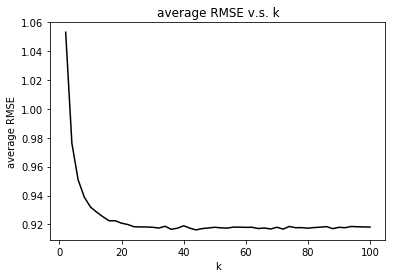

In [17]:
plt.plot(range(2,102,2), rmse_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average RMSE')
plt.title('average RMSE v.s. k')
plt.show()

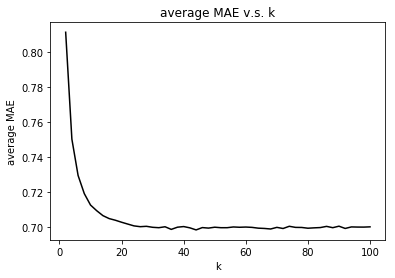

In [18]:
plt.plot(range(2,102,2), mae_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average MAE')
plt.title('average MAE v.s. k')
plt.show()

# Question 11

The 'minimum k' is 20. Accordingly the steady state values of average RMSE is 0.914 and average MAE is 0.698.

# Question 12

In [19]:
# Count the number of movies rated
movie = data['movieId'].values
movie_counts = dict()
for i in movie:
    movie_counts[i] = movie_counts.get(i,0)+1

In [20]:
rmse_arg = list()
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
sim_options = {'name': 'pearson', 'user_based': True}
kf = KFold(n_splits=10)

# Sweep k (number of neighbors) from 2 to 100 instep sizes of 2
for k in range(2,102,2):
    # Define a k-NN collaborative filter
    knn = KNNWithMeans(k = k, sim_options = sim_options)
    rmse = list()
    for trainset, testset in kf.split(data_s):
        # Train the k-NN filter on the train set
        knn.fit(trainset)
        # Trim the test set into the popular movie trimmed test set
        trimmed_testset = list()
        for userId,movieId,rating in testset:
            if (movie_counts.get(movieId)) > 2:
                trimmed_testset.append((userId,movieId,rating))
        # Predict in the trimmed test set
        predictions = knn.test(trimmed_testset)
        # Compute and print Root Mean Squared Error
        rmse.append(accuracy.rmse(predictions, verbose = True))
    # Compute the average of RMSE
    rmse_arg.append(np.mean(rmse))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0598
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0439
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0439
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0480
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0502
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0423
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0423
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0324
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0281
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0443
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9587
Computing 

Done computing similarity matrix.
RMSE: 0.8909
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9071
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8991
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9074
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8984
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9085
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8885
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9211
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9077
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8972
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8968
Computing the pearson similarity matrix...
Done compu

RMSE: 0.8994
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8951
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9068
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8879
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9082
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8893
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9006
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8949
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8926
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8934
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8980
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.88

Done computing similarity matrix.
RMSE: 0.8985
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9082
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9090
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8911
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9013
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8906
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8915
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9016
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9125
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8952
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8918
Computing the pearson similarity matrix...
Done compu

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9043
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9118
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8970
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9042
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8972
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8977
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8990
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8937
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9036
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8989
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8962
Computing 

Done computing similarity matrix.
RMSE: 0.8964
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8867
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9051
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8989
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9170
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8882
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8960
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8950
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8994
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9037
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9063
Computing the pearson similarity matrix...
Done compu

The minimum average RMSE is 0.8977


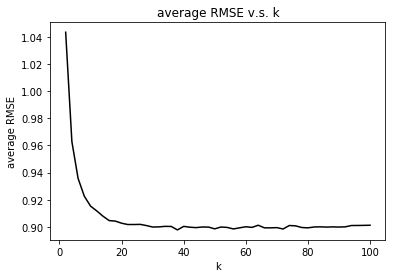

In [21]:
print('The minimum average RMSE is %.4f'%min(rmse_arg))

plt.plot(range(2,102,2), rmse_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average RMSE')
plt.title('average RMSE v.s. k')
plt.show()

# Question 13

In [22]:
rmse_arg = list()
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
sim_options = {'name': 'pearson', 'user_based': True}
kf = KFold(n_splits=10)

# Sweep k (number of neighbors) from 2 to 100 instep sizes of 2
for k in range(2,102,2):
    # Define a k-NN collaborative filter
    knn = KNNWithMeans(k = k, sim_options = sim_options)
    rmse = list()
    for trainset, testset in kf.split(data_s):
        # Train the k-NN filter on the train set
        knn.fit(trainset)
        # Trim the test set into the unpopular movie trimmed test set
        trimmed_testset = list()
        for userId,movieId,rating in testset:
            if (movie_counts.get(movieId)) <= 2:
                trimmed_testset.append((userId,movieId,rating))
        # Predict in the trimmed test set
        predictions = knn.test(trimmed_testset)
        # Compute and print Root Mean Squared Error
        rmse.append(accuracy.rmse(predictions, verbose = True))
    # Compute the average of RMSE
    rmse_arg.append(np.mean(rmse))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1028
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2346
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1844
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1652
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2332
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1751
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1822
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1645
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1924
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2233
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2214
Computing 

Done computing similarity matrix.
RMSE: 1.2126
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1832
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1960
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1915
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1369
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2063
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2032
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1763
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1899
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1630
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2029
Computing the pearson similarity matrix...
Done compu

Done computing similarity matrix.
RMSE: 1.1328
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1092
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2008
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2118
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2278
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1941
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1486
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1344
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2037
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1368
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1929
Computing the pearson similarity matrix...
Done compu

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1394
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1751
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1892
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1677
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1889
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2385
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1813
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2368
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1650
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1143
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1312
Computing 

Done computing similarity matrix.
RMSE: 1.1848
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1749
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1442
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1745
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2359
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1674
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1815
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2041
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1821
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1343
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2492
Computing the pearson similarity matrix...
Done compu

Done computing similarity matrix.
RMSE: 1.2283
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2061
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2022
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2195
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1172
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1719
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1420
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1309
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1974
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2220
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1656
Computing the pearson similarity matrix...
Done compu

The minimum average RMSE is 1.1756


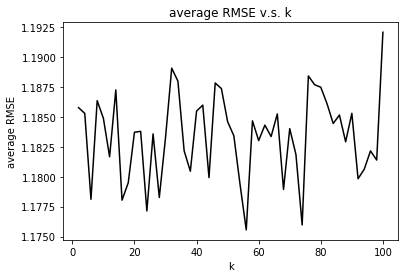

In [23]:
print('The minimum average RMSE is %.4f'%min(rmse_arg))

plt.plot(range(2,102,2), rmse_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average RMSE')
plt.title('average RMSE v.s. k')
plt.show()

# Question 14

In [24]:
rmse_arg = list()
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
sim_options = {'name': 'pearson', 'user_based': True}
kf = KFold(n_splits=10)

# Sweep k (number of neighbors) from 2 to 100 instep sizes of 2
for k in range(2,102,2):
    # Define a k-NN collaborative filter
    knn = KNNWithMeans(k = k, sim_options = sim_options)
    rmse = list()
    for trainset, testset in kf.split(data_s):
        # Train the k-NN filter on the train set
        knn.fit(trainset)
        # Trim the test set into the high variance movie trimmed test set
        trimmed_testset = list()
        for userId,movieId,rating in testset:
            if (movie_variance[movieid.index(movieId)]) >= 2:
                if (movie_counts.get(movieId)) >= 5:
                    trimmed_testset.append((userId,movieId,rating))
        # Predict in the trimmed test set
        predictions = knn.test(trimmed_testset)
        # Compute and print Root Mean Squared Error
        rmse.append(accuracy.rmse(predictions, verbose = True))
    # Compute the average of RMSE
    rmse_arg.append(np.mean(rmse))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6950
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5485
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5052
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.8042
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 2.0352
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.8332
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7860
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.9524
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6608
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7100
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3626
Computing 

Done computing similarity matrix.
RMSE: 1.6942
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3865
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6078
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6986
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6156
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4569
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7864
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6925
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5999
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6848
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7402
Computing the pearson similarity matrix...
Done compu

RMSE: 1.5254
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.8570
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.8370
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4291
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4683
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4922
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6801
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7605
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5523
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6512
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6681
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.42

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5558
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5523
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4826
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7647
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4901
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6317
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3207
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3937
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.8978
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6947
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3621
Computing 

Done computing similarity matrix.
RMSE: 1.7562
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4557
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6532
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6577
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5364
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5999
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.8151
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5410
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3520
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6407
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7063
Computing the pearson similarity matrix...
Done compu

RMSE: 1.7038
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5308
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5321
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3694
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7362
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5488
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.9076
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5160
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7621
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.8018
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2012
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.54

The minimum average RMSE is 1.5698


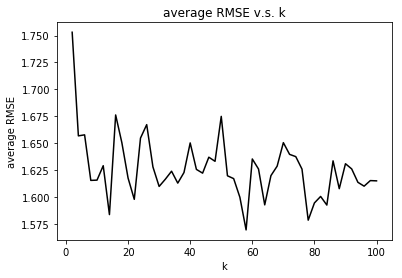

In [25]:
print('The minimum average RMSE is %.4f'%min(rmse_arg))

plt.plot(range(2,102,2), rmse_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average RMSE')
plt.title('average RMSE v.s. k')
plt.show()

# Question 15

In [26]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)
    
    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.set_title('ROC Curve')

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


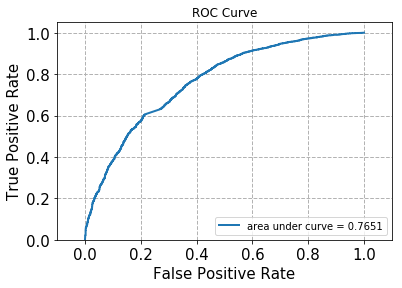

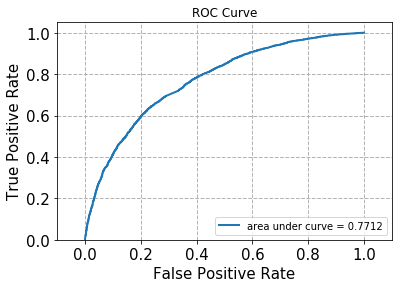

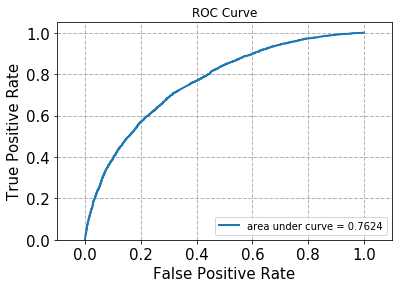

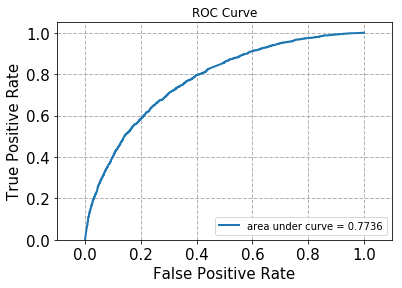

In [27]:
thresholds = [2.5, 3, 3.5, 4]
for i in range(len(thresholds)):
    reader = Reader(line_format='user item rating timestamp', sep = '\t')
    data_s = Dataset.load_from_df(data, reader=reader)
    data_thre = data_s
    trainset, testset = train_test_split(data_thre, test_size=0.1)
    for j in range(len(testset)):
        (userID, movieID, rating) = testset[j]
        if rating > thresholds[i]:
            testset[j] = (userID, movieID, 1)
        elif rating <= thresholds[i]:
            testset[j] = (userID, movieID, 0)
    
    sim_options = {'name': 'pearson','user_based': True}
    knn = KNNWithMeans(k=20, min_k=2, sim_options=sim_options)
    knn.fit(trainset)
    predictions = knn.test(testset)
    
    labels_test = list()
    labels_pre = list()
    for uid, iid, r_ui, est, details in predictions:
        labels_pre.append(est)
    for uid, iid, r_ui in testset:
        labels_test.append(r_ui)
    fpr, tpr, threshold = roc_curve(labels_test, labels_pre)
    plot_roc(fpr, tpr)

# Question 16

Yes, it is convex.

# Question 17

In [28]:
from surprise import NMF

# Transfrorm data into the form available for surprise
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
# Set Pearson and user_based mode
#sim_options = {'name': 'pearson', 'user_based': True}

rmse_arg = list()
mae_arg = list()

# Sweep k from 2 to 52 instep sizes of 2
for k in range(2,52,2):
    # Define a NNMF-based collaborative filter
    svd = NMF(n_factors = k)
    perf = cross_validate(svd, data_s, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    rmse_arg.append(sum(perf['test_rmse'])/10)
    mae_arg.append(sum(perf['test_mae'])/10)

The minimum average RMSE is 0.9379


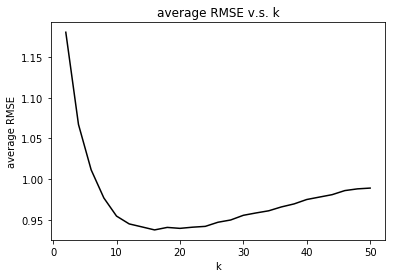

In [29]:
print('The minimum average RMSE is %.4f'%min(rmse_arg))

plt.plot(range(2,52,2), rmse_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average RMSE')
plt.title('average RMSE v.s. k')
plt.show()

The minimum average MAE is 0.7136


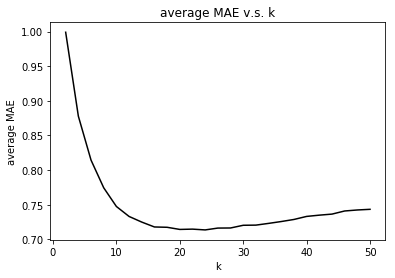

In [30]:
print('The minimum average MAE is %.4f'%min(mae_arg))

plt.plot(range(2,52,2), mae_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average MAE')
plt.title('average MAE v.s. k')
plt.show()

# Question 18

Optimal number of latent factors is 20. 

minimum average RMSE is 0.9379.

minimum average MAE is 0.7136.

Yes, the optimal number of latent factors is 20 and the number of movie genres is 20, they are the same.

# Question 19

In [34]:
rmse_arg = list()
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
#sim_options = {'name': 'pearson', 'user_based': True}
kf = KFold(n_splits=10)

# Sweep k from 2 to 52 instep sizes of 2
for k in range(2,52,2):
    # Define a NNMF collaborative filter
    nmf = NMF(n_factors = k)
    rmse = list()
    for trainset, testset in kf.split(data_s):
        # Train the NNMF filter on the train set
        nmf.fit(trainset)
        # Trim the test set into the popular movie trimmed test set
        trimmed_testset = list()
        for userId,movieId,rating in testset:
            if (movie_counts.get(movieId)) > 2:
                trimmed_testset.append((userId,movieId,rating))
        # Predict in the trimmed test set
        predictions = nmf.test(trimmed_testset)
        # Compute and print Root Mean Squared Error
        rmse.append(accuracy.rmse(predictions, verbose = True))
    # Compute the average of RMSE
    rmse_arg.append(np.mean(rmse))

RMSE: 1.1773
RMSE: 1.1647
RMSE: 1.1748
RMSE: 1.1590
RMSE: 1.1745
RMSE: 1.1709
RMSE: 1.1808
RMSE: 1.1642
RMSE: 1.1737
RMSE: 1.1776
RMSE: 1.0491
RMSE: 1.0595
RMSE: 1.0596
RMSE: 1.0649
RMSE: 1.0530
RMSE: 1.0598
RMSE: 1.0455
RMSE: 1.0580
RMSE: 1.0658
RMSE: 1.0524
RMSE: 0.9796
RMSE: 0.9989
RMSE: 0.9937
RMSE: 1.0030
RMSE: 0.9925
RMSE: 0.9918
RMSE: 1.0019
RMSE: 0.9815
RMSE: 0.9836
RMSE: 0.9970
RMSE: 0.9602
RMSE: 0.9633
RMSE: 0.9526
RMSE: 0.9577
RMSE: 0.9550
RMSE: 0.9408
RMSE: 0.9597
RMSE: 0.9703
RMSE: 0.9536
RMSE: 0.9513
RMSE: 0.9299
RMSE: 0.9467
RMSE: 0.9424
RMSE: 0.9329
RMSE: 0.9365
RMSE: 0.9382
RMSE: 0.9391
RMSE: 0.9422
RMSE: 0.9330
RMSE: 0.9415
RMSE: 0.9290
RMSE: 0.9212
RMSE: 0.9164
RMSE: 0.9277
RMSE: 0.9151
RMSE: 0.9397
RMSE: 0.9225
RMSE: 0.9353
RMSE: 0.9173
RMSE: 0.9155
RMSE: 0.9306
RMSE: 0.9183
RMSE: 0.9264
RMSE: 0.9204
RMSE: 0.9157
RMSE: 0.9188
RMSE: 0.9062
RMSE: 0.9219
RMSE: 0.9215
RMSE: 0.9240
RMSE: 0.9235
RMSE: 0.9180
RMSE: 0.9094
RMSE: 0.9283
RMSE: 0.9170
RMSE: 0.9220
RMSE: 0.9167

The minimum average RMSE is 0.9190


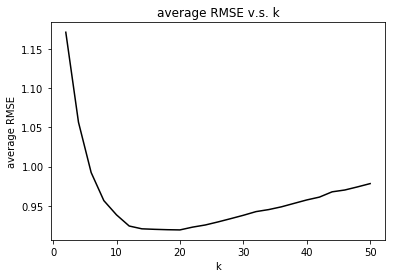

In [35]:
print('The minimum average RMSE is %.4f'%min(rmse_arg))

plt.plot(range(2,52,2), rmse_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average RMSE')
plt.title('average RMSE v.s. k')
plt.show()

# Question 20

In [36]:
rmse_arg = list()
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
#sim_options = {'name': 'pearson', 'user_based': True}
kf = KFold(n_splits=10)

# Sweep k (number of neighbors) from 2 to 100 instep sizes of 2
for k in range(2,52,2):
    # Define a k-NN collaborative filter
    nmf = NMF(n_factors = k)
    rmse = list()
    for trainset, testset in kf.split(data_s):
        # Train the k-NN filter on the train set
        nmf.fit(trainset)
        # Trim the test set into the unpopular movie trimmed test set
        trimmed_testset = list()
        for userId,movieId,rating in testset:
            if (movie_counts.get(movieId)) <= 2:
                trimmed_testset.append((userId,movieId,rating))
        # Predict in the trimmed test set
        predictions = nmf.test(trimmed_testset)
        # Compute and print Root Mean Squared Error
        rmse.append(accuracy.rmse(predictions, verbose = True))
    # Compute the average of RMSE
    rmse_arg.append(np.mean(rmse))

RMSE: 1.2938
RMSE: 1.2697
RMSE: 1.2606
RMSE: 1.3036
RMSE: 1.3323
RMSE: 1.2456
RMSE: 1.2693
RMSE: 1.2437
RMSE: 1.2290
RMSE: 1.2917
RMSE: 1.2267
RMSE: 1.2209
RMSE: 1.2935
RMSE: 1.2088
RMSE: 1.2949
RMSE: 1.2590
RMSE: 1.2750
RMSE: 1.3161
RMSE: 1.2787
RMSE: 1.2594
RMSE: 1.2938
RMSE: 1.2891
RMSE: 1.2279
RMSE: 1.2425
RMSE: 1.2264
RMSE: 1.2097
RMSE: 1.2264
RMSE: 1.2613
RMSE: 1.2110
RMSE: 1.2387
RMSE: 1.2248
RMSE: 1.2866
RMSE: 1.2261
RMSE: 1.1974
RMSE: 1.2933
RMSE: 1.2689
RMSE: 1.2415
RMSE: 1.3043
RMSE: 1.2392
RMSE: 1.1809
RMSE: 1.2628
RMSE: 1.1746
RMSE: 1.2024
RMSE: 1.2701
RMSE: 1.2555
RMSE: 1.2379
RMSE: 1.2512
RMSE: 1.2295
RMSE: 1.2428
RMSE: 1.2661
RMSE: 1.1380
RMSE: 1.2349
RMSE: 1.2362
RMSE: 1.2470
RMSE: 1.2514
RMSE: 1.2019
RMSE: 1.2434
RMSE: 1.2914
RMSE: 1.1838
RMSE: 1.2970
RMSE: 1.1810
RMSE: 1.2607
RMSE: 1.2970
RMSE: 1.2876
RMSE: 1.3098
RMSE: 1.2061
RMSE: 1.1665
RMSE: 1.1855
RMSE: 1.1951
RMSE: 1.2778
RMSE: 1.2986
RMSE: 1.2496
RMSE: 1.1640
RMSE: 1.2292
RMSE: 1.1992
RMSE: 1.2115
RMSE: 1.2601

The minimum average RMSE is 1.2110


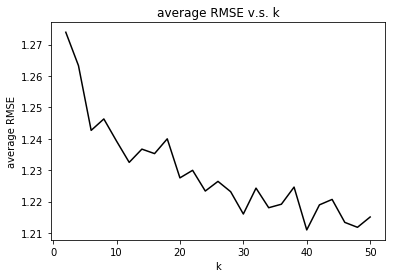

In [37]:
print('The minimum average RMSE is %.4f'%min(rmse_arg))

plt.plot(range(2,52,2), rmse_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average RMSE')
plt.title('average RMSE v.s. k')
plt.show()

# Question 21

In [38]:
rmse_arg = list()
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
#sim_options = {'name': 'pearson', 'user_based': True}
kf = KFold(n_splits=10)

# Sweep k (number of neighbors) from 2 to 100 instep sizes of 2
for k in range(2,52,2):
    # Define a k-NN collaborative filter
    nmf = NMF(n_factors = k)
    rmse = list()
    for trainset, testset in kf.split(data_s):
        # Train the k-NN filter on the train set
        nmf.fit(trainset)
        # Trim the test set into the high variance movie trimmed test set
        trimmed_testset = list()
        for userId,movieId,rating in testset:
            if (movie_variance[movieid.index(movieId)]) >= 2:
                if (movie_counts.get(movieId)) >= 5:
                    trimmed_testset.append((userId,movieId,rating))
        # Predict in the trimmed test set
        predictions = nmf.test(trimmed_testset)
        # Compute and print Root Mean Squared Error
        rmse.append(accuracy.rmse(predictions, verbose = True))
    # Compute the average of RMSE
    rmse_arg.append(np.mean(rmse))

RMSE: 1.6186
RMSE: 1.5434
RMSE: 1.6590
RMSE: 1.7484
RMSE: 2.1484
RMSE: 1.5464
RMSE: 1.6909
RMSE: 1.6806
RMSE: 1.7622
RMSE: 1.6840
RMSE: 1.4982
RMSE: 1.4306
RMSE: 1.6925
RMSE: 1.7975
RMSE: 1.7789
RMSE: 1.6746
RMSE: 1.7813
RMSE: 1.6744
RMSE: 1.8967
RMSE: 1.7693
RMSE: 1.6853
RMSE: 1.4762
RMSE: 1.7783
RMSE: 1.3533
RMSE: 1.5808
RMSE: 1.8628
RMSE: 1.9118
RMSE: 1.3909
RMSE: 1.8815
RMSE: 1.6050
RMSE: 1.6485
RMSE: 1.8476
RMSE: 1.8602
RMSE: 1.7560
RMSE: 1.8076
RMSE: 1.6724
RMSE: 1.7344
RMSE: 1.5797
RMSE: 1.7485
RMSE: 1.4754
RMSE: 1.6634
RMSE: 1.5799
RMSE: 1.7306
RMSE: 1.4977
RMSE: 1.3739
RMSE: 1.7299
RMSE: 1.6323
RMSE: 1.8468
RMSE: 1.7975
RMSE: 1.4380
RMSE: 1.7980
RMSE: 1.5854
RMSE: 1.6382
RMSE: 1.6436
RMSE: 1.6956
RMSE: 1.7014
RMSE: 1.7194
RMSE: 1.6333
RMSE: 1.4936
RMSE: 1.7039
RMSE: 1.4776
RMSE: 1.7685
RMSE: 1.7842
RMSE: 1.6917
RMSE: 1.5823
RMSE: 1.7709
RMSE: 1.6629
RMSE: 1.6471
RMSE: 1.6543
RMSE: 1.6492
RMSE: 1.4389
RMSE: 1.6296
RMSE: 1.6646
RMSE: 1.4736
RMSE: 1.6385
RMSE: 1.7432
RMSE: 1.8801

The minimum average RMSE is 1.6184


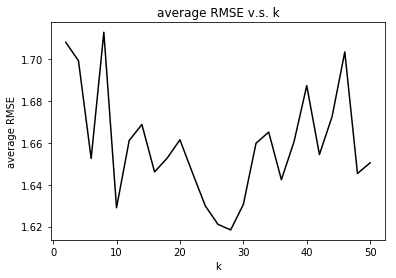

In [39]:
print('The minimum average RMSE is %.4f'%min(rmse_arg))

plt.plot(range(2,52,2), rmse_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average RMSE')
plt.title('average RMSE v.s. k')
plt.show()

# Question 22

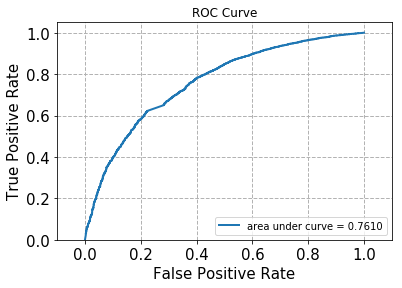

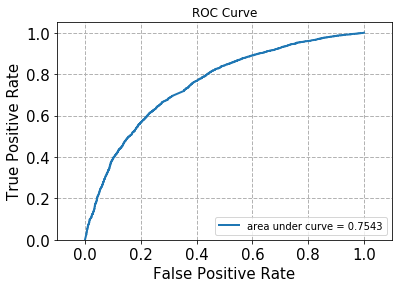

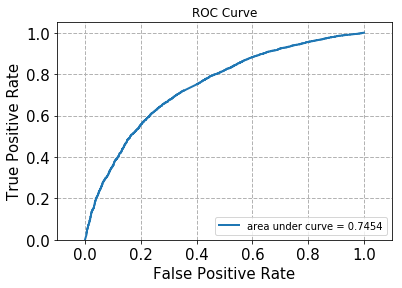

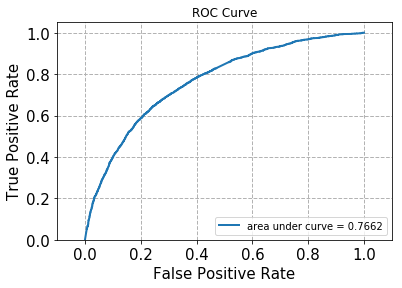

In [41]:
thresholds = [2.5, 3, 3.5, 4]
for i in range(len(thresholds)):
    reader = Reader(line_format='user item rating timestamp', sep = '\t')
    data_sp = Dataset.load_from_df(data, reader=reader)
    trainset, testset = train_test_split(data_sp, test_size=0.1)
    for j in range(len(testset)):
        (userID, movieID, rating) = testset[j]
        if rating > thresholds[i]:
            testset[j] = (userID, movieID, 1)
        elif rating <= thresholds[i]:
            testset[j] = (userID, movieID, 0)
    
    #sim_options = {'name': 'pearson','user_based': True}
    algo = NMF(n_factors=20)
    #trainset, testset = train_test_split(data_thre, test_size=0.1)
    algo.fit(trainset)
    predictions = algo.test(testset)
    
    labels_test = list()
    labels_pre = list()
    for uid, iid, r_ui, est, details in predictions:
        labels_pre.append(est)
    for uid, iid, r_ui in testset:
        labels_test.append(r_ui)
    fpr, tpr, threshold = roc_curve(labels_test, labels_pre)
    plot_roc(fpr, tpr)

# Question 23

In [42]:
from surprise import NMF
reader = Reader(line_format='user item rating timestamp', sep = '\t')
data_sp = Dataset.load_from_df(data, reader=reader)
trainset = data_sp.build_full_trainset()

algo = NMF(n_factors=20)
algo.fit(trainset)

U = algo.pu
V = algo.qi

In [43]:
top = np.ones((10, 20), dtype=int)

In [44]:
top[0,0]

1

In [45]:
for k in range(20):
    V_arg = np.argsort(V[:,k])
    V1 = V[V_arg]
    V_0 = V1[9056:9067, k]
    #print(V_0)
    index = [0,0,0,0,0,0,0,0,0,0]
    for j in range(10):
        for i in range(9066):
            if V[i, k] == V_0[j]:
                index[j] = i
        #print(index)
    for m in range(10):
        id = index[m]
        top[m, k] = list(movie_counts.keys())[id]

In [46]:
top

array([[ 55250,    670,   8914,   3973,   2135,   8190,   2459,    190,
         98961,    255,   7027,   8908,   7247,   4248,   1744,  71033,
          7064,  80551,  39183,  87522],
       [ 51412,   4566,     38,   3908,   6450,   6223,   4406,   2267,
          4835,   3573,   3577,   2594, 114662,   1180,    190,  31433,
         31694,  85510,   8275,   6772],
       [  1173,   3415,   2024,  26084,   3777,   2732,  31364,  27478,
         65188,   4483,   5957,  91104,   3235,   5927,   3920,   8366,
          2043,    714,   5255, 114180],
       [ 71838,    444,   3896,  48322,    250,   2929,   4133,   2810,
          2236,   7369,   3725,    279,   5382,   5705,   3503,  70533,
          2386,   1824,   8376,   3833],
       [   169,   1546,   2905,   1655,  27178,   2348,  72395,   4930,
        103048,  75341,    714,   5172,    483,   6294,   1932,   1978,
        119145,  26025,    547,  89837],
       [ 91104,   1005,  32853,   3813,  30810,   4603,    443,   2483,
   

In [50]:
movie = pd.read_csv('ml-latest-small/ratings.csv', usecols = [0,1,2])
movie = movie.as_matrix()
itemindex = np.argwhere(movie[:, 0] == 3785)

In [51]:
movie[itemindex, 2]

array([], shape=(0, 1), dtype=float64)

In [52]:
for i in range(20):
    genre = list()
    for j in range(10):
        itemindex = np.argwhere(movie[:, 0] == top[j, i])
        genre.append(movie[itemindex, 2])
    print(genre)   

[array([], shape=(0, 1), dtype=float64), array([], shape=(0, 1), dtype=float64), array([], shape=(0, 1), dtype=float64), array([], shape=(0, 1), dtype=float64), array([[ 4. ],
       [ 1.5],
       [ 3.5],
       [ 2. ],
       [ 3.5],
       [ 5. ],
       [ 5. ],
       [ 3.5],
       [ 3.5],
       [ 3. ],
       [ 4. ],
       [ 3.5],
       [ 4. ],
       [ 1. ],
       [ 3.5],
       [ 4. ],
       [ 5. ],
       [ 4. ],
       [ 4.5],
       [ 3. ],
       [ 3.5],
       [ 3.5],
       [ 2.5],
       [ 5. ],
       [ 4. ],
       [ 2. ],
       [ 5. ],
       [ 5. ],
       [ 3.5],
       [ 5. ],
       [ 5. ],
       [ 3.5],
       [ 4.5],
       [ 5. ],
       [ 3.5],
       [ 4. ],
       [ 5. ],
       [ 4.5],
       [ 5. ],
       [ 4.5],
       [ 5. ],
       [ 5. ],
       [ 4.5],
       [ 1. ],
       [ 3.5],
       [ 4.5],
       [ 5. ],
       [ 5. ],
       [ 3.5],
       [ 5. ],
       [ 5. ],
       [ 3. ],
       [ 2.5],
       [ 4. ],
       [ 3. ],
       [ 4.5],

In [53]:
V_arg = np.argsort(V[:,0])
V1 = V[V_arg]

In [54]:
V1_0 = V1[9056:9067, 0]
index = [0,0,0,0,0,0,0,0,0,0]
for j in range(10):
    for i in range(9066):
        if V[i, 0] == V1_0[j]:
            index[j] = i
index

[8467, 5244, 759, 1618, 549, 8468, 3404, 3926, 4087, 5609]

In [55]:
for i in range(10):
    id = index[i]
    print(list(movie_counts.keys())[id])

55250
51412
1173
71838
169
91104
250
62912
2275
67788


In [56]:
V_arg2 = np.argsort(V[:,1])
V2 = V[V_arg2]
V2_0 = V2[9056:9067, 1]
index2 = [0,0,0,0,0,0,0,0,0,0]
for j in range(10):
    for i in range(9066):
        if V[i, 1] == V2_0[j]:
            index2[j] = i
for i in range(10):
    id = index2[i]
    print(list(movie_counts.keys())[id])

670
4566
3415
444
1546
1005
279
99
2903
1824


In [57]:
V_arg3 = np.argsort(V[:,2])
V3 = V[V_arg3]
V3_0 = V3[9056:9067, 2]
index3 = [0,0,0,0,0,0,0,0,0,0]
for j in range(10):
    for i in range(9066):
        if V[i, 2] == V3_0[j]:
            index3[j] = i
for i in range(10):
    id = index3[i]
    print(list(movie_counts.keys())[id])

8914
38
2024
3896
2905
32853
241
3218
580
7706


In [58]:
V_arg4 = np.argsort(V[:,3])
V4 = V[V_arg4]
V4_0 = V4[9056:9067, 3]
index4 = [0,0,0,0,0,0,0,0,0,0]
for j in range(10):
    for i in range(9066):
        if V[i, 3] == V4_0[j]:
            index4[j] = i
for i in range(10):
    id = index4[i]
    print(list(movie_counts.keys())[id])

3973
3908
26084
48322
1655
3813
2346
1875
99
2738


In [59]:
V_arg5 = np.argsort(V[:,4])
V5 = V[V_arg5]
V5_0 = V5[9056:9067, 4]
index5 = [0,0,0,0,0,0,0,0,0,0]
for j in range(10):
    for i in range(9066):
        if V[i, 4] == V5_0[j]:
            index5[j] = i
for i in range(10):
    id = index5[i]
    print(list(movie_counts.keys())[id])

2135
6450
3777
250
27178
30810
1085
4492
70565
3865


# Question 24

In [60]:
from surprise import SVD

# Transfrorm data into the form available for surprise
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
# Set Pearson and user_based mode
#sim_options = {'name': 'pearson', 'user_based': True}

rmse_arg = list()
mae_arg = list()

# Sweep k from 2 to 52 instep sizes of 2
for k in range(2,52,2):
    # Define a MF with bias collaborative filter
    svd = SVD(n_factors = k)
    perf = cross_validate(svd, data_s, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    rmse_arg.append(sum(perf['test_rmse'])/10)
    mae_arg.append(sum(perf['test_mae'])/10)

The minimum average RMSE is 0.8870


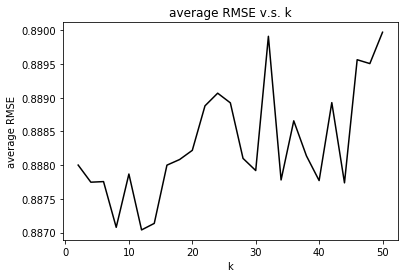

In [61]:
print('The minimum average RMSE is %.4f'%min(rmse_arg))

plt.plot(range(2,52,2), rmse_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average RMSE')
plt.title('average RMSE v.s. k')
plt.show()

The minimum average MAE is 0.6826


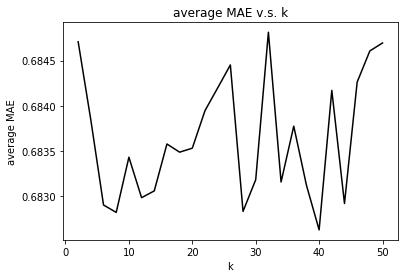

In [62]:
print('The minimum average MAE is %.4f'%min(mae_arg))

plt.plot(range(2,52,2), mae_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average MAE')
plt.title('average MAE v.s. k')
plt.show()

# Question 25

Optimal number of latent factors is 20. 

Minimum average RMSE is 0.8867.

Minimum average MAE is 0.6821.

# Question 26

In [63]:
rmse_arg = list()
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
#sim_options = {'name': 'pearson', 'user_based': True}
kf = KFold(n_splits=10)

# Sweep k from 2 to 52 instep sizes of 2
for k in range(2,52,2):
    # Define a NNMF collaborative filter
    svd = SVD(n_factors = k)
    rmse = list()
    for trainset, testset in kf.split(data_s):
        # Train the NNMF filter on the train set
        svd.fit(trainset)
        # Trim the test set into the popular movie trimmed test set
        trimmed_testset = list()
        for userId,movieId,rating in testset:
            if (movie_counts.get(movieId)) > 2:
                trimmed_testset.append((userId,movieId,rating))
        # Predict in the trimmed test set
        predictions = svd.test(trimmed_testset)
        # Compute and print Root Mean Squared Error
        rmse.append(accuracy.rmse(predictions, verbose = True))
    # Compute the average of RMSE
    rmse_arg.append(np.mean(rmse))

RMSE: 0.8732
RMSE: 0.8897
RMSE: 0.8789
RMSE: 0.8759
RMSE: 0.8824
RMSE: 0.8914
RMSE: 0.8677
RMSE: 0.8717
RMSE: 0.8853
RMSE: 0.8784
RMSE: 0.8892
RMSE: 0.8736
RMSE: 0.8886
RMSE: 0.8785
RMSE: 0.8859
RMSE: 0.8686
RMSE: 0.8709
RMSE: 0.8832
RMSE: 0.8795
RMSE: 0.8854
RMSE: 0.8752
RMSE: 0.8776
RMSE: 0.8880
RMSE: 0.8794
RMSE: 0.8846
RMSE: 0.8678
RMSE: 0.8845
RMSE: 0.8759
RMSE: 0.8807
RMSE: 0.8816
RMSE: 0.8741
RMSE: 0.8819
RMSE: 0.8862
RMSE: 0.8830
RMSE: 0.8919
RMSE: 0.8621
RMSE: 0.8790
RMSE: 0.8776
RMSE: 0.8793
RMSE: 0.8901
RMSE: 0.8757
RMSE: 0.8798
RMSE: 0.8879
RMSE: 0.8841
RMSE: 0.8759
RMSE: 0.8912
RMSE: 0.8735
RMSE: 0.8779
RMSE: 0.8793
RMSE: 0.8776
RMSE: 0.8771
RMSE: 0.8889
RMSE: 0.8788
RMSE: 0.8718
RMSE: 0.8749
RMSE: 0.8809
RMSE: 0.8777
RMSE: 0.8783
RMSE: 0.8736
RMSE: 0.8911
RMSE: 0.8825
RMSE: 0.8815
RMSE: 0.8750
RMSE: 0.8777
RMSE: 0.8811
RMSE: 0.8771
RMSE: 0.8810
RMSE: 0.8894
RMSE: 0.8753
RMSE: 0.8681
RMSE: 0.8713
RMSE: 0.8829
RMSE: 0.8775
RMSE: 0.8806
RMSE: 0.8868
RMSE: 0.8771
RMSE: 0.8754

The minimum average RMSE is 0.8789


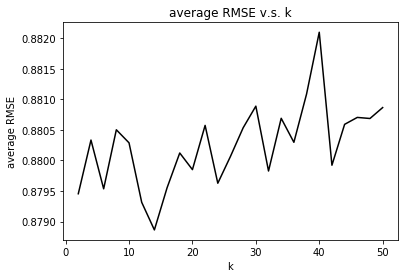

In [64]:
print('The minimum average RMSE is %.4f'%min(rmse_arg))

plt.plot(range(2,52,2), rmse_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average RMSE')
plt.title('average RMSE v.s. k')
plt.show()

# Question 27

In [65]:
rmse_arg = list()
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
#sim_options = {'name': 'pearson', 'user_based': True}
kf = KFold(n_splits=10)

# Sweep k (number of neighbors) from 2 to 52 instep sizes of 2
for k in range(2,52,2):
    # Define a k-NN collaborative filter
    svd = SVD(n_factors = k)
    rmse = list()
    for trainset, testset in kf.split(data_s):
        # Train the k-NN filter on the train set
        svd.fit(trainset)
        # Trim the test set into the unpopular movie trimmed test set
        trimmed_testset = list()
        for userId,movieId,rating in testset:
            if (movie_counts.get(movieId)) <= 2:
                trimmed_testset.append((userId,movieId,rating))
        # Predict in the trimmed test set
        predictions = svd.test(trimmed_testset)
        # Compute and print Root Mean Squared Error
        rmse.append(accuracy.rmse(predictions, verbose = True))
    # Compute the average of RMSE
    rmse_arg.append(np.mean(rmse))

RMSE: 0.9705
RMSE: 1.0041
RMSE: 1.0730
RMSE: 1.0022
RMSE: 1.0072
RMSE: 1.0142
RMSE: 0.9838
RMSE: 0.9969
RMSE: 1.0355
RMSE: 0.9972
RMSE: 0.9592
RMSE: 0.9889
RMSE: 1.0585
RMSE: 1.0098
RMSE: 1.0330
RMSE: 1.0190
RMSE: 1.0637
RMSE: 1.0084
RMSE: 0.9809
RMSE: 0.9815
RMSE: 0.9905
RMSE: 1.0220
RMSE: 1.0019
RMSE: 0.9632
RMSE: 1.0005
RMSE: 1.0688
RMSE: 0.9834
RMSE: 1.0657
RMSE: 1.0438
RMSE: 1.0017
RMSE: 1.0449
RMSE: 0.9863
RMSE: 1.0352
RMSE: 1.0139
RMSE: 1.0159
RMSE: 1.0218
RMSE: 0.9932
RMSE: 0.9802
RMSE: 1.0097
RMSE: 1.0184
RMSE: 0.9901
RMSE: 1.0249
RMSE: 1.0606
RMSE: 1.0163
RMSE: 0.9491
RMSE: 0.9922
RMSE: 1.0318
RMSE: 1.0814
RMSE: 0.9966
RMSE: 0.9837
RMSE: 0.9950
RMSE: 0.9637
RMSE: 1.0106
RMSE: 0.9842
RMSE: 1.0165
RMSE: 1.0440
RMSE: 1.0670
RMSE: 0.9710
RMSE: 1.0299
RMSE: 1.0383
RMSE: 1.0111
RMSE: 1.0362
RMSE: 0.9660
RMSE: 0.9510
RMSE: 0.9799
RMSE: 1.0167
RMSE: 1.1187
RMSE: 1.0222
RMSE: 1.0019
RMSE: 0.9869
RMSE: 1.0051
RMSE: 1.0198
RMSE: 1.0033
RMSE: 1.0899
RMSE: 1.0140
RMSE: 1.0164
RMSE: 1.0109

The minimum average RMSE is 1.0084


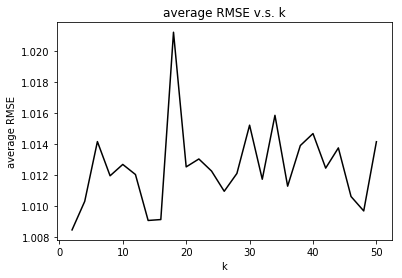

In [66]:
print('The minimum average RMSE is %.4f'%min(rmse_arg))

plt.plot(range(2,52,2), rmse_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average RMSE')
plt.title('average RMSE v.s. k')
plt.show()

# Question 28

In [67]:
rmse_arg = list()
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
#sim_options = {'name': 'pearson', 'user_based': True}
kf = KFold(n_splits=10)

# Sweep k (number of neighbors) from 2 to 100 instep sizes of 2
for k in range(2,52,2):
    # Define a k-NN collaborative filter
    svd = SVD(n_factors = k)
    rmse = list()
    #mae = list()
    for trainset, testset in kf.split(data_s):
        # Train the k-NN filter on the train set
        svd.fit(trainset)
        # Trim the test set into the high variance movie trimmed test set
        trimmed_testset = list()
        for userId,movieId,rating in testset:
            if (movie_variance[movieid.index(movieId)]) >= 2:
                if (movie_counts.get(movieId)) >= 5:
                    trimmed_testset.append((userId,movieId,rating))
        # Predict in the trimmed test set
        predictions = svd.test(trimmed_testset)
        # Compute and print Root Mean Squared Error
        rmse.append(accuracy.rmse(predictions, verbose = True))
        # Compute and print Mean Absolute Error
        #mae.append(accuracy.mae(predictions, verbose = True))
    # Compute the average of RMSE and MAE
    rmse_arg.append(np.mean(rmse))

RMSE: 1.3005
RMSE: 1.5581
RMSE: 1.4834
RMSE: 1.6425
RMSE: 1.3777
RMSE: 1.4924
RMSE: 1.4981
RMSE: 1.5289
RMSE: 1.4249
RMSE: 1.5506
RMSE: 1.3694
RMSE: 1.5683
RMSE: 1.1899
RMSE: 1.4362
RMSE: 1.5710
RMSE: 1.6612
RMSE: 1.4679
RMSE: 1.4519
RMSE: 1.6064
RMSE: 1.4185
RMSE: 1.4344
RMSE: 1.4927
RMSE: 1.4300
RMSE: 1.5002
RMSE: 1.6240
RMSE: 1.4881
RMSE: 1.5881
RMSE: 1.5271
RMSE: 1.4691
RMSE: 1.4959
RMSE: 1.5845
RMSE: 1.3929
RMSE: 1.5413
RMSE: 1.4200
RMSE: 1.5235
RMSE: 1.3919
RMSE: 1.6758
RMSE: 1.5231
RMSE: 1.5380
RMSE: 1.5016
RMSE: 1.3734
RMSE: 1.6234
RMSE: 1.5675
RMSE: 1.5328
RMSE: 1.7178
RMSE: 1.5493
RMSE: 1.3643
RMSE: 1.5733
RMSE: 1.2687
RMSE: 1.4189
RMSE: 1.5489
RMSE: 1.3733
RMSE: 1.5132
RMSE: 1.4435
RMSE: 1.5763
RMSE: 1.5367
RMSE: 1.4246
RMSE: 1.4561
RMSE: 1.5250
RMSE: 1.5075
RMSE: 1.5912
RMSE: 1.4180
RMSE: 1.5339
RMSE: 1.4905
RMSE: 1.5911
RMSE: 1.5317
RMSE: 1.5309
RMSE: 1.3415
RMSE: 1.4683
RMSE: 1.5249
RMSE: 1.5427
RMSE: 1.3721
RMSE: 1.6341
RMSE: 1.6451
RMSE: 1.3578
RMSE: 1.5220
RMSE: 1.4429

The minimum average RMSE is 1.4741


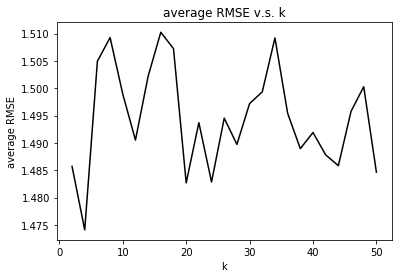

In [68]:
print('The minimum average RMSE is %.4f'%min(rmse_arg))

plt.plot(range(2,52,2), rmse_arg, color = 'black')
plt.xlabel('k')
plt.ylabel('average RMSE')
plt.title('average RMSE v.s. k')
plt.show()

# Question 29

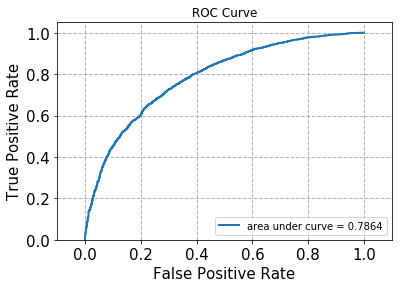

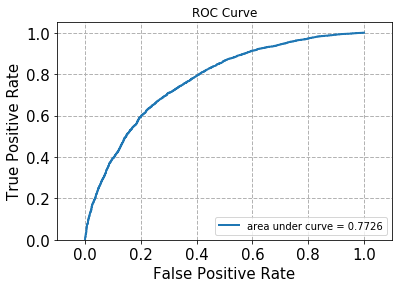

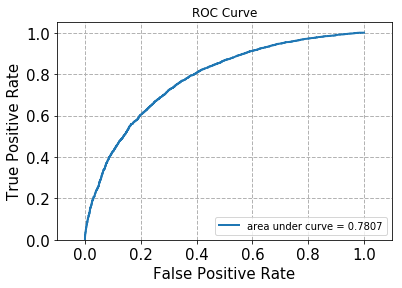

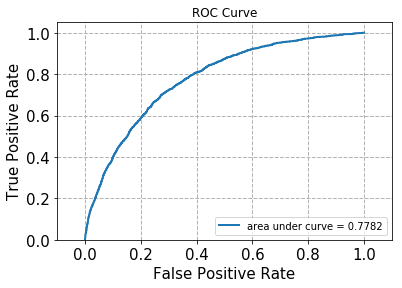

In [70]:
thresholds = [2.5, 3, 3.5, 4]
for i in range(len(thresholds)):
    reader = Reader(line_format='user item rating timestamp', sep = '\t')
    data_sp = Dataset.load_from_df(data, reader=reader)
    trainset, testset = train_test_split(data_sp, test_size=0.1)
    for j in range(len(testset)):
        (userID, movieID, rating) = testset[j]
        if rating > thresholds[i]:
            testset[j] = (userID, movieID, 1)
        elif rating <= thresholds[i]:
            testset[j] = (userID, movieID, 0)
    
    #sim_options = {'name': 'pearson','user_based': True}
    algo = SVD(n_factors=20)
    #trainset, testset = train_test_split(data_thre, test_size=0.1)
    algo.fit(trainset)
    predictions = algo.test(testset)
    
    labels_test = list()
    labels_pre = list()
    for uid, iid, r_ui, est, details in predictions:
        labels_pre.append(est)
    for uid, iid, r_ui in testset:
        labels_test.append(r_ui)
    fpr, tpr, threshold = roc_curve(labels_test, labels_pre)
    plot_roc(fpr, tpr)

# Question 30

In [73]:
from sklearn.metrics import auc, roc_curve, mean_squared_error

user = data['userId'].values
user_counts = dict()
for i in user:
    user_counts[i] = user_counts.get(i,0)+1
user_num = len(user_counts.keys())

# Count the number of movies rated
movie = data['movieId'].values
movie_counts = dict()
for i in movie:
    movie_counts[i] = movie_counts.get(i,0)+1
    
start_point = 0
end_point = 0
user_rate_mean = {}
for i in range(1,user_num+1):
    end_point+=user_counts[i]
    user_rate_mean[i] = np.mean(data['rating'][start_point:end_point])
    start_point = end_point+1
    
#naive on whole dataset
kf = KFold(n_splits=10,shuffle = True)
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
user_rate = []
rms = []
predict_one = []
k = 0
for test_index in kf.split(data_s):
    user_rate = []
    predict_one = []
    for userId,movieId,rating in test_index[1]:
        user_rate.append(rating)
        predict_one.append(user_rate_mean[userId])
    rms.append(np.sum(np.sqrt(mean_squared_error(user_rate, predict_one)))/len(test_index[1]))
print(len(rms),np.sum(rms)/len(rms))

10 9.55440093902e-05


# Question 31

In [74]:
#naive on popular
kf = KFold(n_splits=10,shuffle = True)
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
movie_rate = []
rms = []
predict_movie = []

for test_index in kf.split(data_s):
    movie_rate = []
    predict_movie = []
    trimmed_testset = []
    for userId,movieId,rating in test_index[1]:
        if (movie_counts.get(movieId)) > 2:
            trimmed_testset.append((userId,movieId,rating))
            movie_rate.append(rating)
            predict_movie.append(user_rate_mean[userId])
    rms.append(np.sum(np.sqrt(mean_squared_error(movie_rate, predict_movie)))/len(trimmed_testset))
print(len(rms),np.sum(rms)/len(rms))

10 0.000100724708046


# Question 32

In [75]:
#naive on unpopular
kf = KFold(n_splits=10,shuffle = True)
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
movie_low_rate = []
rms = []
predict_low_movie = []

for test_index in kf.split(data_s):
    movie_low_rate = []
    predict_low_movie = []
    trimmed_low_testset = []
    for userId,movieId,rating in test_index[1]:
        if (movie_counts.get(movieId)) <= 2:
            trimmed_low_testset.append((userId,movieId,rating))
            movie_low_rate.append(rating)
            predict_low_movie.append(user_rate_mean[userId])
    rms.append(np.sum(np.sqrt(mean_squared_error(movie_low_rate, predict_low_movie)))/len(trimmed_low_testset))
print(len(rms),np.sum(rms)/len(rms))

10 0.00184949669272


# Question 33

In [76]:
movie_variance = list()
for m in movieid:
    tmp = list()
    for u in userid:
        if R[u-1,m-1] != 0:
            tmp.append(R[u-1,m-1])
    m_var = np.var(tmp)
    movie_variance.append(m_var)

In [77]:
#naive on high variance
kf = KFold(n_splits=10,shuffle = True)
reader = Reader(line_format='user item rating timestamp', sep='\t')
data_s = Dataset.load_from_df(data, reader=reader)
movie_high_rate = []
rms = []
predict_high_movie = []

for test_index in kf.split(data_s):
    movie_high_rate = []
    predict_high_movie = []
    trimmed_high_testset = []
    for userId,movieId,rating in test_index[1]:
        if (movie_variance[movieid.index(movieId)]) >= 2:
                if (movie_counts.get(movieId)) >= 5:
                    trimmed_high_testset.append((userId,movieId,rating))
                    movie_high_rate.append(rating)
                    predict_high_movie.append(user_rate_mean[userId])
    rms.append(np.sum(np.sqrt(mean_squared_error(movie_high_rate, predict_high_movie)))/len(trimmed_high_testset))
print(len(rms),np.sum(rms)/len(rms))

10 0.0362555335505


# Question 34

Computing the pearson similarity matrix...
Done computing similarity matrix.


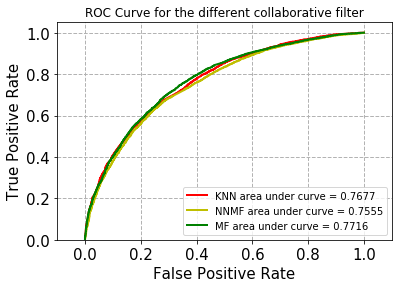

In [78]:
reader = Reader(line_format='user item rating timestamp', sep = '\t')
data_sp = Dataset.load_from_df(data, reader=reader)
trainset, testset = train_test_split(data_sp, test_size=0.1)

for j in range(len(testset)):
        (userID, movieID, rating) = testset[j]
        if rating > 3:
            testset[j] = (userID, movieID, 1)
        elif rating <= 3:
            testset[j] = (userID, movieID, 0)

from surprise import KNNWithMeans
# k-NN collaborative filters
sim_options = {'name': 'pearson','user_based': True}
knn = KNNWithMeans(k=20, min_k=2, sim_options=sim_options)
knn.fit(trainset)
predictions1 = knn.test(testset)

# Plot ROC curve
labels_test = list()
labels_pre1 = list()
for uid1, iid1, r_ui1, est1, details1 in predictions1:
    labels_pre1.append(est1)
for uid, iid, r_ui in testset:
    labels_test.append(r_ui)
fpr1, tpr1, threshold1 = roc_curve(labels_test, labels_pre1)
#plot_roc(fpr1, tpr1)
roc_auc1 = auc(fpr1,tpr1)

from surprise import NMF
# NNMF collaborative filters
nmf = NMF(n_factors=20)
nmf.fit(trainset)
predictions2 = nmf.test(testset)

# Plot ROC curve
#labels_test2 = list()
labels_pre2 = list()
for uid2, iid2, r_ui2, est2, details2 in predictions2:
    labels_pre2.append(est2)
#for uid, iid, r_ui in testset:
#    labels_test.append(r_ui)
fpr2, tpr2, threshold2 = roc_curve(labels_test, labels_pre2)
#plot_roc(fpr2, tpr2)
roc_auc2 = auc(fpr2, tpr2)

from surprise import SVD
# MF with bias
svd = SVD(n_factors=20)
svd.fit(trainset)
predictions3 = svd.test(testset)

# Plot ROC curve
#labels_test3 = list()
labels_pre3 = list()
for uid3, iid3, r_ui3, est3, details3 in predictions3:
    labels_pre3.append(est3)
#for uid, iid, r_ui in testset:
#    labels_test.append(r_ui)
fpr3, tpr3, threshold3 = roc_curve(labels_test, labels_pre3)
#plot_roc(fpr3, tpr3)
roc_auc3 = auc(fpr3, tpr3)

fig, ax = plt.subplots()
ax.plot(fpr1, tpr1, lw=2, label= 'KNN area under curve = %0.4f' % roc_auc1, color = 'r')
ax.plot(fpr2, tpr2, lw=2, label= 'NNMF area under curve = %0.4f' % roc_auc2, color = 'y')
ax.plot(fpr3, tpr3, lw=2, label= 'MF area under curve = %0.4f' % roc_auc3, color = 'g')
ax.grid(color='0.7', linestyle='--', linewidth=1)
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.set_ylabel('True Positive Rate',fontsize=15)
ax.set_title('ROC Curve for the different collaborative filter')
ax.legend(loc="lower right")
for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontsize(15)

plt.show()

# Question 35

As is given by these two equations below, the precision in this case is the ratio between the number of correct recommendation given by the system and the number of all the recommendation given by the system. And "correct" here means the movie given by the system is truly liked by the user. Similarly, the recall in this case is the ratio between the number of the correct recommendation given by the system and the number of all the items liked by the user, where "correct" has the same meaning as precision.
$$ Precision(t)=\frac{|S(t)\cap G|}{| S(t) |}$$
$$ Recall(t)=\frac{|S(t)\cap G|}{|G|}$$

# Question 36

In [34]:
def precision_recall_at_k(predictions, k=5, threshold=3):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        if len(user_ratings) < k:
            continue
        elif n_rel == 0:
            continue
        

        # Number of recommended items in top k
        n_rec_k = k

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [46]:
precisions_arg_knn = list()
recalls_arg_knn = list()

for i in range(1,26):
    reader = Reader(line_format='user item rating timestamp', sep = '\t')
    data_s = Dataset.load_from_df(data, reader=reader)
    kf = KFold(n_splits=10, random_state = 42)
    sim_options = {'name': 'pearson','user_based': True}
    knn = KNNWithMeans(k = 20, sim_options = sim_options, random_state = 42)

    for trainset, testset in kf.split(data_s):
        knn.fit(trainset)
        predictions = knn.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=3)
        # Average the precision and recall
    prec_arg = sum(prec for prec in precisions.values())/len(precisions)
    rec_arg = sum(rec for rec in recalls.values())/len(recalls)
    precisions_arg_knn.append(prec_arg)
    recalls_arg_knn.append(rec_arg)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

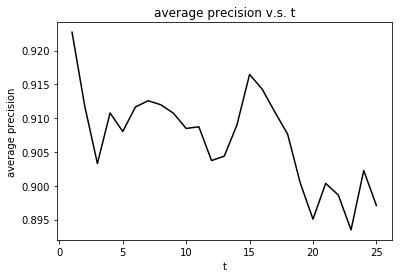

In [47]:
plt.plot(range(1,26), precisions_arg_knn, color = 'black')
plt.xlabel('t')
plt.ylabel('average precision')
plt.title('average precision v.s. t')
plt.show()

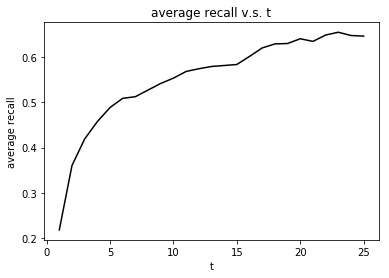

In [45]:
plt.plot(range(1,26), recalls_arg_knn, color = 'black')
plt.xlabel('t')
plt.ylabel('average recall')
plt.title('average recall v.s. t')
plt.show()

# Question 37

In [48]:
from surprise import NMF
precisions_arg_nmf = list()
recalls_arg_nmf = list()

for i in range(1,26):
    reader = Reader(line_format='user item rating timestamp', sep = '\t')
    data_s = Dataset.load_from_df(data, reader=reader)
    kf = KFold(n_splits=10, random_state = 42)
    nmf = NMF(n_factors = 20, random_state = 42)
    
    for trainset, testset in kf.split(data_s):
        nmf.fit(trainset)
        predictions = nmf.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=3)
        # Average the precision and recall
    prec_arg = sum(prec for prec in precisions.values())/len(precisions)
    rec_arg = sum(rec for rec in recalls.values())/len(recalls)
    precisions_arg_nmf.append(prec_arg)
    recalls_arg_nmf.append(rec_arg)

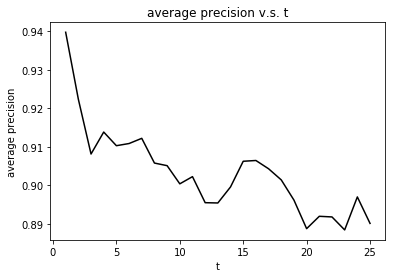

In [49]:
plt.plot(range(1,26), precisions_arg_nmf, color = 'black')
plt.xlabel('t')
plt.ylabel('average precision')
plt.title('average precision v.s. t')
plt.show()

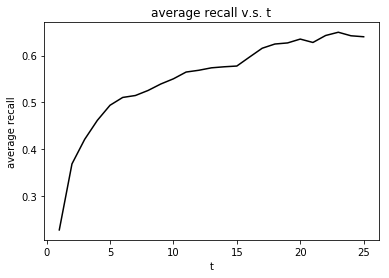

In [50]:
plt.plot(range(1,26), recalls_arg_nmf, color = 'black')
plt.xlabel('t')
plt.ylabel('average recall')
plt.title('average recall v.s. t')
plt.show()

# Question 38

In [51]:
from surprise import SVD
precisions_arg_svd = list()
recalls_arg_svd = list()

for i in range(1,26):
    reader = Reader(line_format='user item rating timestamp', sep = '\t')
    data_s = Dataset.load_from_df(data, reader=reader)
    kf = KFold(n_splits=10, random_state = 42)
    svd = SVD(n_factors = 20, random_state = 42)
    
    for trainset, testset in kf.split(data_s):
        svd.fit(trainset)
        predictions = svd.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=3)
        # Average the precision and recall
    prec_arg = sum(prec for prec in precisions.values())/len(precisions)
    rec_arg = sum(rec for rec in recalls.values())/len(recalls)
    precisions_arg_svd.append(prec_arg)
    recalls_arg_svd.append(rec_arg)

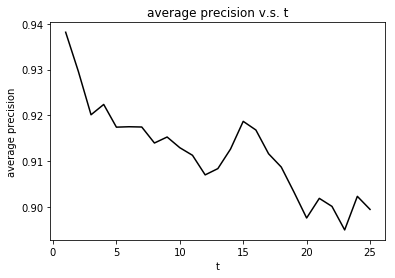

In [52]:
plt.plot(range(1,26), precisions_arg_svd, color = 'black')
plt.xlabel('t')
plt.ylabel('average precision')
plt.title('average precision v.s. t')
plt.show()

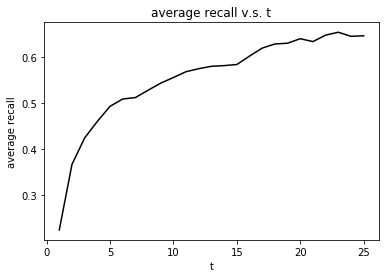

In [53]:
plt.plot(range(1,26), recalls_arg_svd, color = 'black')
plt.xlabel('t')
plt.ylabel('average recall')
plt.title('average recall v.s. t')
plt.show()

# Question 39

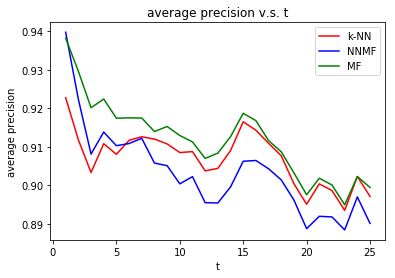

In [54]:
line1 = plt.plot(range(1,26), precisions_arg_knn, color = 'r', label = 'k-NN')
line2 = plt.plot(range(1,26), precisions_arg_nmf, color = 'b', label = 'NNMF')
line3 = plt.plot(range(1,26), precisions_arg_svd, color = 'g', label = 'MF')
plt.xlabel('t')
plt.ylabel('average precision')
plt.title('average precision v.s. t')
plt.legend()
plt.show()

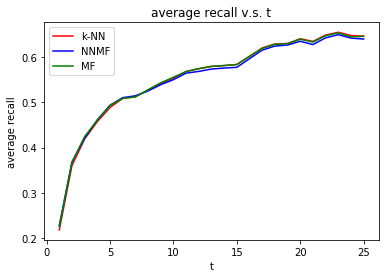

In [57]:
line1 = plt.plot(range(1,26), recalls_arg_knn, color = 'r', label = 'k-NN')
line2 = plt.plot(range(1,26), recalls_arg_nmf, color = 'b', label = 'NNMF')
line3 = plt.plot(range(1,26), recalls_arg_svd, color = 'g', label = 'MF')
plt.xlabel('t')
plt.ylabel('average recall')
plt.title('average recall v.s. t')
plt.legend()
plt.show()

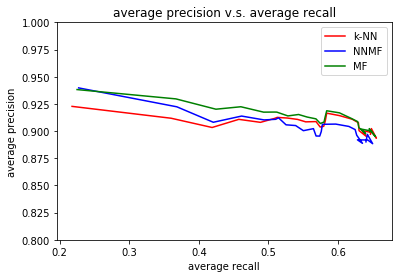

In [62]:
line1 = plt.plot(recalls_arg_knn, precisions_arg_knn, color = 'r', label = 'k-NN')
line2 = plt.plot(recalls_arg_nmf, precisions_arg_nmf, color = 'b', label = 'NNMF')
line3 = plt.plot(recalls_arg_svd, precisions_arg_svd, color = 'g', label = 'MF')
plt.xlabel('average recall')
plt.ylabel('average precision')
plt.title('average precision v.s. average recall')
plt.ylim(0.8,1)
plt.legend()
plt.show()